In [1]:
from main import *
from useful_functions import *
from visualization import *
from stats import *

from brainspace.gradient.embedding import DiffusionMaps

%matplotlib inline
plt.rcParams['font.size'] = 18

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

atlas = MapzebrainAtlas(atlas_path)
excluded = np.load('Results/excluded_regions.npy')

centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')
centroids = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)

In [3]:
FC = np.load('Results/FC_matrix.npy')
SC = np.load('Results/undirected_terminals_expanded.npy')

# Loading region series

In [4]:
datasets = get_datasets(top_directory, ['920nm', 'wholebrain'])

In [5]:
sigma = 2
rseries = []
for ds in datasets:
    rseries.append(np.load(ds + 'region_series_dff.npy')[:, :])
    for i in range(rseries[-1].shape[0]):
        rseries[-1][i] = gaussian_filter1d(rseries[-1][i], sigma)

matrices = []
for ts in rseries:
    matrix = compute_correlation_matrix(ts)
    matrix[np.isnan(matrix)] = 0
    matrices.append(matrix)
matrices = np.stack(matrices, axis=0)

matrices = np.delete(matrices, excluded, axis=1)
matrices = np.delete(matrices, excluded, axis=2)

FC2 = np.mean(matrices, axis=0)

# Functional network gradients

In [6]:
map = DiffusionMaps(n_components=2)
embedding = map.fit_transform(FC)
gradient1f = embedding[:, 0].flatten()
gradient2f = embedding[:, 1].flatten()

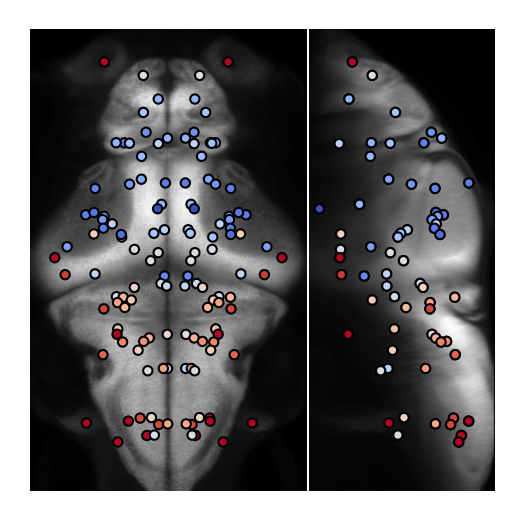

In [7]:
v = np.percentile(np.abs(gradient1f), 90)
plot_regional_values(gradient1f, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

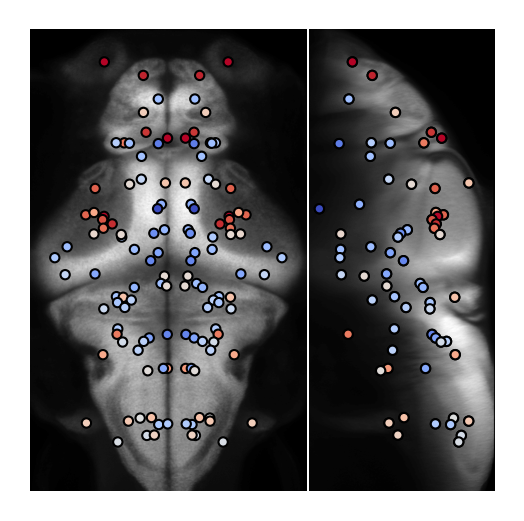

In [8]:
v = np.percentile(np.abs(gradient2f), 95)
plot_regional_values(gradient2f, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

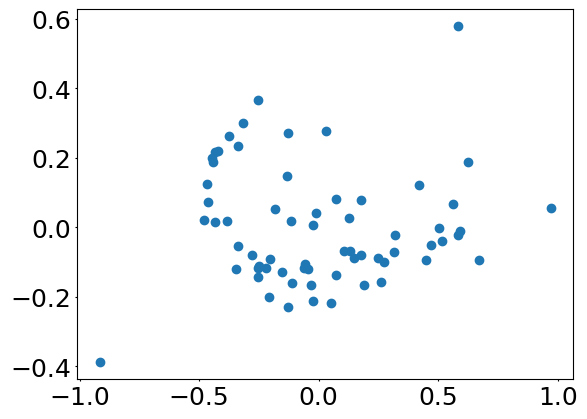

In [52]:
plt.scatter(gradient1f, gradient2f)

# Structural network gradients

In [9]:
%matplotlib inline

In [81]:
map = DiffusionMaps(n_components=10)
embedding = map.fit_transform(SC)
gradient1s = np.delete(embedding[:, 0].flatten(), excluded)
gradient2s = np.delete(embedding[:, 1].flatten(), excluded)

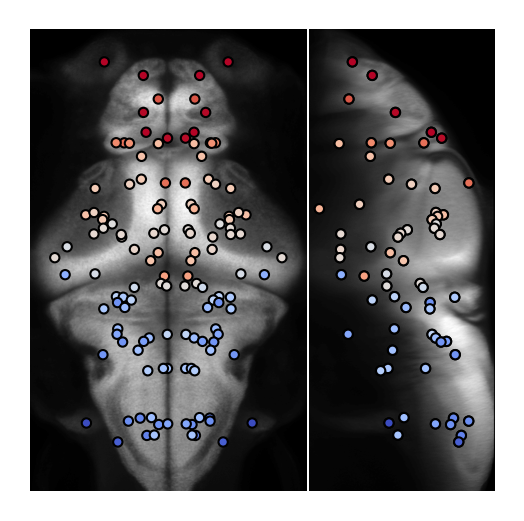

In [82]:
v = np.percentile(np.abs(gradient1s), 95)
plot_regional_values(gradient1s, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

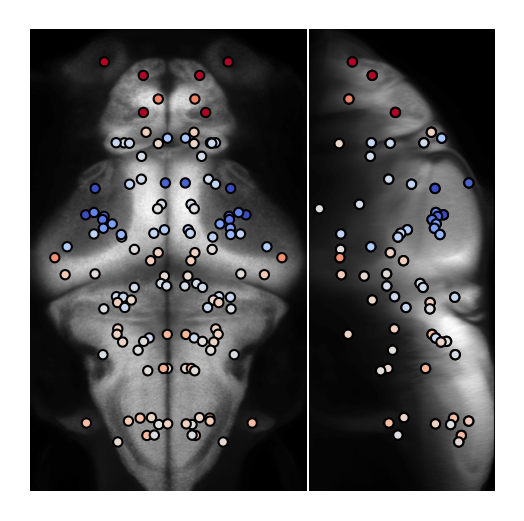

In [12]:
v = np.percentile(np.abs(gradient2s), 95)
plot_regional_values(gradient2s, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

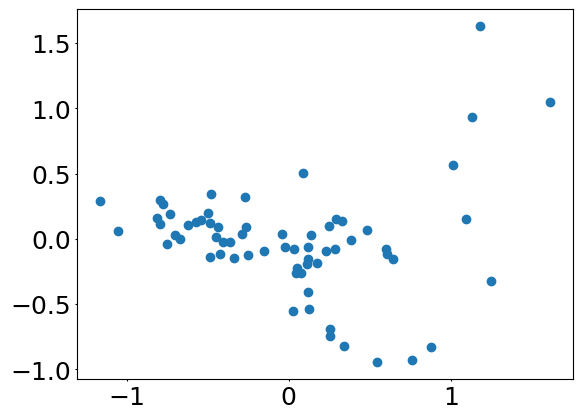

In [51]:
plt.scatter(gradient1s, gradient2s)

# Computing sensorimotor index per brain region

In [13]:
N_neurons_per_region = np.load('Results/N_neurons_per_region.npy')

In [14]:
corrs_per_region_dark, cells_per_region_dark = [], []
corrs_per_region_motor, cells_per_region_motor = [], []

for folder in tqdm(datasets, file=sys.stdout):

    if 'correlated_motor.npy' in identify_files(folder, ['.npy']):

        coprd, ceprd = [], []
        coprm, ceprm = [], []
        
        data = load_data(folder)
        corrs_dark = np.load(folder + 'correlations_dark.npy')
        corrs_motor = np.load(folder + 'correlations_motor.npy')
        cells_dark = np.load(folder + 'correlated_dark.npy')
        cells_motor = np.load(folder + 'correlated_motor.npy')
        regions = data['region_labels']
    
        for i in range(regions.shape[1]):
            in_region = regions[:, i] > 0
            coprd.append(np.mean(corrs_dark[in_region]))
            ceprd.append(np.sum(cells_dark[in_region]))
            coprm.append(np.mean(corrs_motor[in_region]))
            ceprm.append(np.sum(cells_motor[in_region]))

    corrs_per_region_dark.append(coprd)
    cells_per_region_dark.append(ceprd)
    corrs_per_region_motor.append(coprm)
    cells_per_region_motor.append(ceprm)

corrs_per_region_dark = np.stack(corrs_per_region_dark)
cells_per_region_dark = np.stack(cells_per_region_dark)
corrs_per_region_motor = np.stack(corrs_per_region_motor)
cells_per_region_motor = np.stack(cells_per_region_motor)

corrs_per_region_dark[np.isnan(corrs_per_region_dark)] = 0
corrs_per_region_motor[np.isnan(corrs_per_region_motor)] = 0

  5%|██                                          | 1/22 [00:00<00:16,  1.24it/s]

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


100%|███████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


In [15]:
fraction_dark = np.mean(cells_per_region_dark, axis=0) / (np.mean(N_neurons_per_region, axis=0) + 1)
fraction_motor = np.mean(cells_per_region_motor, axis=0) / (np.mean(N_neurons_per_region, axis=0) + 1)
corrs_dark = np.mean(corrs_per_region_dark, axis=0)
corrs_motor = np.mean(corrs_per_region_motor, axis=0)

In [16]:
score_visual = fraction_dark
score_visual = np.delete(score_visual, excluded)
score_motor = fraction_motor
score_motor = np.delete(score_motor, excluded)

In [17]:
sensorimotor_index = score_visual - score_motor

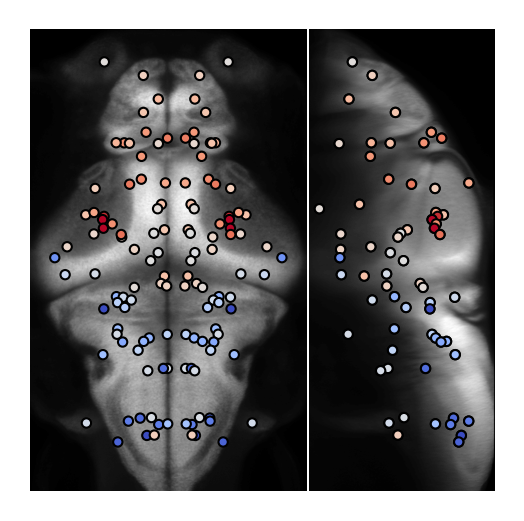

In [408]:
v = np.percentile(np.abs(sensorimotor_index), 95)
plot_regional_values(sensorimotor_index, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

In [19]:
np.save('Results/figure6_sensorimotor_index.npy', sensorimotor_index)

# Comparing gradients with sensorimotor index

In [20]:
from scipy.stats import spearmanr

In [21]:
map = DiffusionMaps(n_components=2)
embedding = map.fit_transform(FC)
gradient1f = embedding[:, 0].flatten()

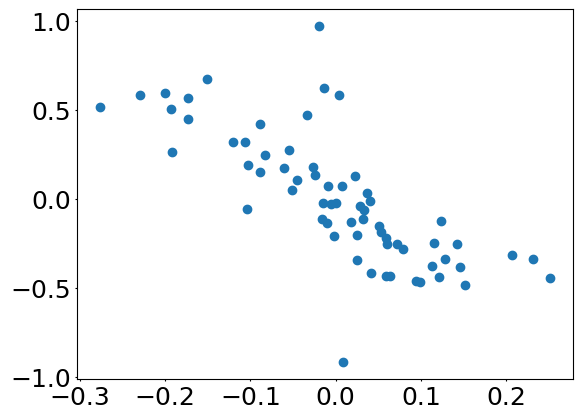

In [22]:
plt.scatter(sensorimotor_index, gradient1f)

In [23]:
spearmanr(sensorimotor_index, gradient1f)

SpearmanrResult(correlation=-0.8465909090909091, pvalue=6.535157198284518e-19)

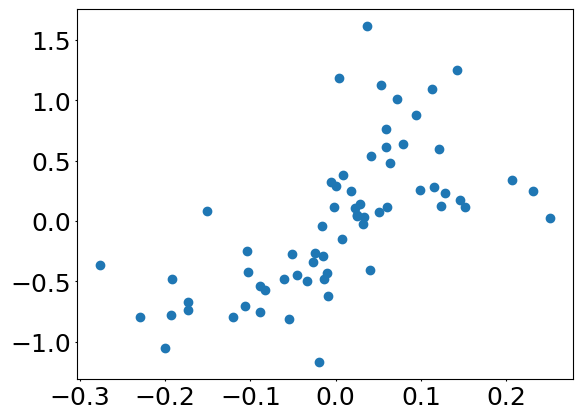

In [24]:
plt.scatter(sensorimotor_index, gradient1s)

In [25]:
spearmanr(sensorimotor_index, gradient1s)

SpearmanrResult(correlation=0.7688811188811189, pvalue=7.473140141090552e-14)

#### Comparing functional diversity

In [29]:
diversity = np.delete(np.load('Results/figure5_adjusted_regional_diversity.npy'), excluded)

In [40]:
diversity

array([ 4.12378337,  7.01869436,  5.43186265,  5.7783849 ,  7.93441618,
        3.66355442,  7.08123945,  2.90817637,  2.42469721,  2.76641531,
        3.44346287,  6.01890219,  3.5924459 ,  4.42953846,  2.76316116,
        3.97038163,  6.02785131,  2.66436317,  2.38918738,  1.69602689,
        2.03902293,  2.39774662,  1.88927963,  4.10348506,  3.35394136,
        4.66282892,  5.20689915,  3.1403622 ,  5.92377714,  3.17821199,
        3.59374899,  1.82051115,  3.23161731,  7.09576925,  3.47825216,
        2.51494547,  4.81426201,  4.29077778,  6.08826107,  3.27025725,
        8.76997328,  3.94336722, 10.49259156,  4.26264097,  2.66725282,
        2.74540865,  2.70948789,  3.77492993,  4.35943616,  3.77629614,
        3.5238606 ,  3.34554294,  6.08208466,  2.78068755,  2.50315169,
        2.79331051,  7.79920767,  3.69533665,  3.24883292,  2.99707907,
        3.06144421,  4.23619382,  2.62584864,  3.03612029,  3.15457331])

# High-resolution gradient

In [ ]:
from sklearn.cluster import KMeans

In [597]:
volumes = np.copy(atlas.relativeVolumes)
volumes[10] = 0
volumes /= np.sum(volumes)

In [598]:
N_clusters_per_region = ((volumes * 423) + 1).astype('int')
N_clusters_per_region[N_clusters_per_region > 1] -= 1

In [612]:
region_centroids = []
region_labels = []

for r in tqdm(range(70), file=sys.stdout):
    N_clusters = N_clusters_per_region[r]
    mask = atlas.getRegionMask(r)[:, :, :284]
    mask = zoom(mask, (0.25, 0.25, 0.25), order=0)
    i, j, k = np.where(mask)
    centroids = np.stack([i, j, k], axis=1)
    kmeans = KMeans(n_clusters=N_clusters).fit(centroids)
    clusters = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_
    
    region_centroids.append(cluster_centroids)
    region_labels += [r] * N_clusters

# Reflecting on other hemisphere
region_centroids_left = np.concatenate(region_centroids, axis=0)
region_centroids_left = np.flip(region_centroids_left, axis=1) * 4
region_centroids_right = np.copy(region_centroids_left)
region_centroids_right[:, 0] = - (region_centroids_right[:, 0] - 284) + 284
region_centroids = np.concatenate([region_centroids_left, region_centroids_right], axis=0)
region_labels = np.array(region_labels + region_labels)

100%|███████████████████████████████████████████| 70/70 [01:15<00:00,  1.08s/it]


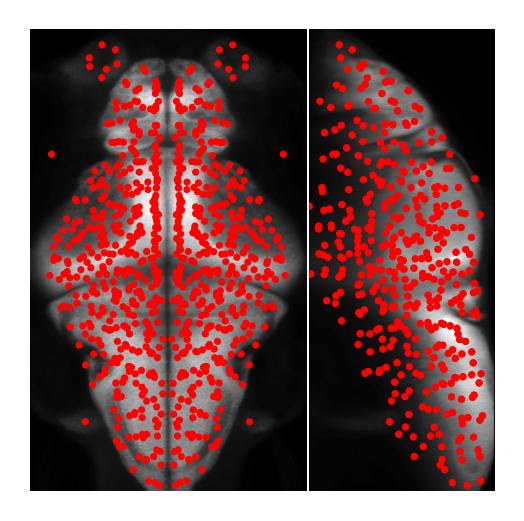

In [613]:
plot_centroids_on_atlas(region_centroids, atlas, alpha=1)

In [616]:
np.save('Results/region_centroids_highres.npy', region_centroids)
np.save('Results/region_labels_highres.npy', region_labels)

# Mapping larvae in high-res parcelation

In [53]:
import warnings

In [54]:
region_centroids_hires = np.load('Results/region_centroids_highres.npy')
region_labels_hires = np.load('Results/region_labels_highres.npy')

In [55]:
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(centroids1, centroids2):
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(centroids2)
    _, indices = nn_model.kneighbors(centroids1)
    return indices.flatten()

In [56]:
N_regions = int(len(region_labels_hires) / 2)

In [57]:
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")

    matrices = []
    N_neurons_all = []
    N_dark_all = []
    N_motor_all = []
    
    for folder in tqdm(datasets, file=sys.stdout):

        if any(identify_files(folder, ['motor.npy'])):
    
            region_series = np.zeros
                
            data = load_data(folder)
            region_labels = data['region_labels']
            region_labels[:, 10] = 0
            in_brain = np.sum(region_labels, axis=1) > 0
            centroids = data['centroids_atlas'][in_brain]
            cells_dark = np.load(folder + 'correlated_dark.npy')[in_brain]
            cells_motor = np.load(folder + 'correlated_motor.npy')[in_brain]
            dff = np.load(folder + 'dff.npy')[in_brain][:, :]
        
            NN = find_nearest_neighbors(centroids, region_centroids_hires)
    
            N_neurons, N_dark, N_motor = [], [], []
            region_series = np.zeros((N_regions * 2, dff.shape[1]))
            for i in range(N_regions * 2):
                c = centroids[NN == i]
                if np.any(c):
                    region_series[i] = gaussian_filter1d(np.mean(dff[NN == i], axis=0), 2)
                    N_neurons.append(c.shape[0])
                    N_dark.append(np.sum(cells_dark[NN == i]))
                    N_motor.append(np.sum(cells_motor[NN == i]))
                else:
                    N_neurons.append(0)
                    N_dark.append(0)
                    N_motor.append(0)
                    
            N_neurons_all.append(N_neurons)
            N_dark_all.append(N_dark)
            N_motor_all.append(N_motor)
                    
            region_series = 0.5 * (region_series[:N_regions] + region_series[N_regions:])
            matrix = np.corrcoef(region_series)
            matrices.append(matrix)

100%|███████████████████████████████████████████| 22/22 [01:53<00:00,  5.17s/it]


In [58]:
N_neurons = np.mean(np.stack(N_neurons_all), axis=0)
N_neurons = 0.5 * (N_neurons[:N_regions] + N_neurons[N_regions:])

N_dark = np.mean(np.stack(N_dark_all), axis=0)
N_dark = 0.5 * (N_dark[:N_regions] + N_dark[N_regions:])

N_motor = np.mean(np.stack(N_motor_all), axis=0)
N_motor = 0.5 * (N_motor[:N_regions] + N_motor[N_regions:])

In [59]:
fraction_dark = N_dark / (N_neurons + 1)
fraction_motor = N_motor / (N_neurons + 1)

In [60]:
sensorimotor_index = fraction_dark - fraction_motor

In [61]:
FC_hi = np.nanmean(np.stack(matrices), axis=0)
FC_hi[np.isnan(FC_hi)] = 0
#FC_hi = np.abs(FC_hi)

/tmp/ipykernel_17163/2337416533.py:1: RuntimeWarning: Mean of empty slice
  FC_hi = np.nanmean(np.stack(matrices), axis=0)


In [62]:
excluded_hi = np.where(np.sum(FC_hi, axis=0) == 0)[0]

In [63]:
FC_hi_ = np.delete(np.delete(FC_hi, excluded_hi, axis=0), excluded_hi, axis=1)
FC_hi_[np.diag_indices(FC_hi_.shape[0])] = 0
FC_hi_[FC_hi_ < 0] = 0

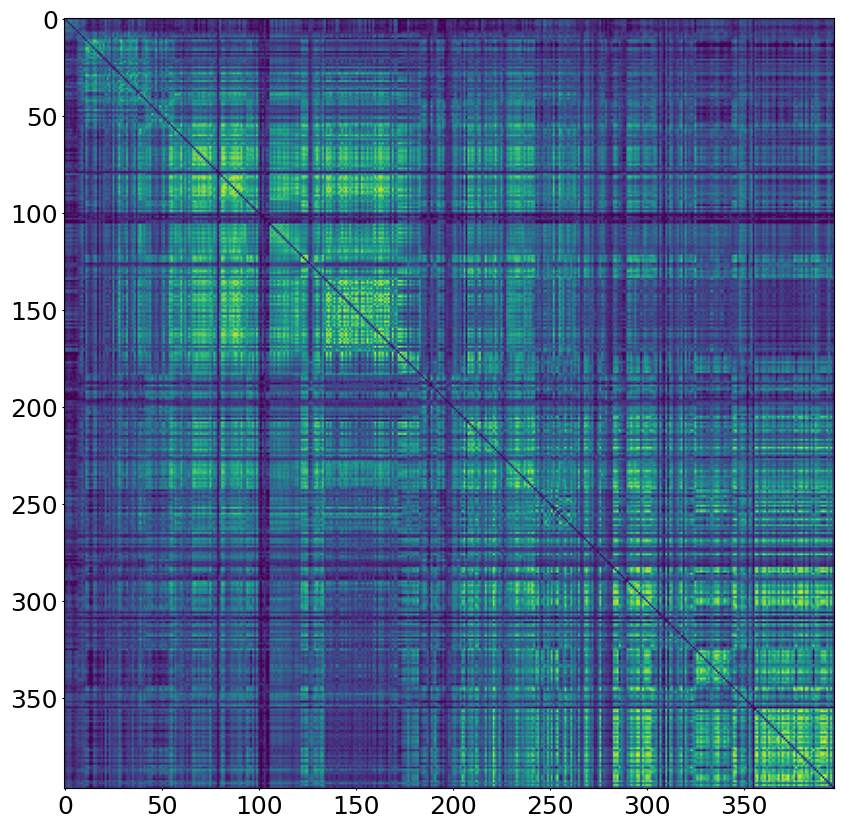

In [64]:
plt.figure(figsize=(10, 10))
plt.imshow(FC_hi_)

In [65]:
map = DiffusionMaps(n_components=2, alpha=0.5)
embedding = map.fit_transform(FC_hi_)
gradient1f_hi = embedding[:, 0].flatten()
gradient2f_hi = embedding[:, 1].flatten()

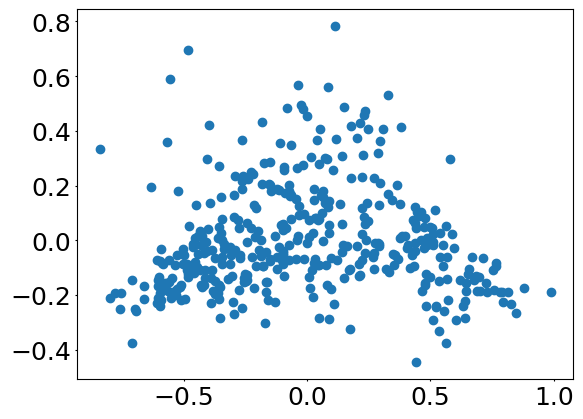

In [80]:
plt.scatter(gradient1f_hi, gradient2f_hi)

In [73]:
e = np.concatenate([excluded_hi, excluded_hi + 401])
c = np.delete(region_centroids_hires, e, axis=0)

(-0.5, 596.5, 973.5, -0.5)

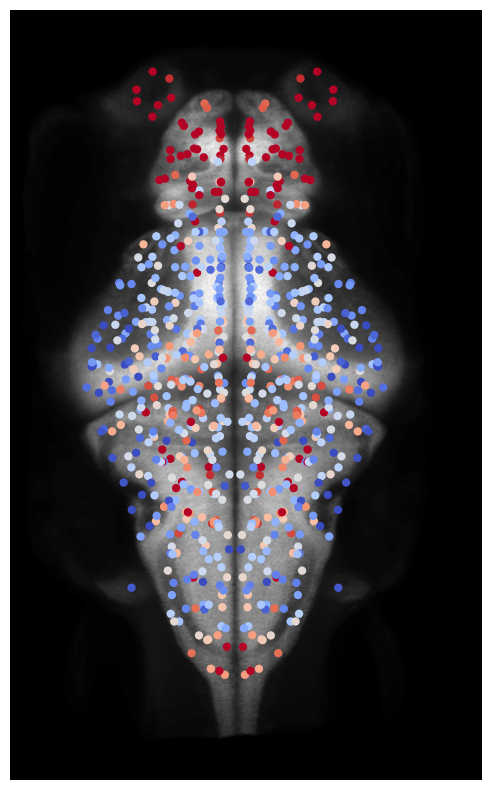

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(c[:, 0], c[:, 1], edgecolor='None', c=double(gradient2f_hi), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 973.5, 358.5, -0.5)

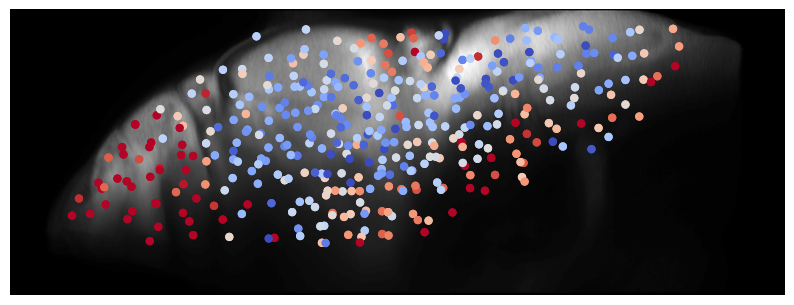

In [77]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(c[:, 1], c[:, 2], edgecolor='None', c=double(gradient2f_hi), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

In [69]:
s = np.delete(sensorimotor_index, excluded_hi)

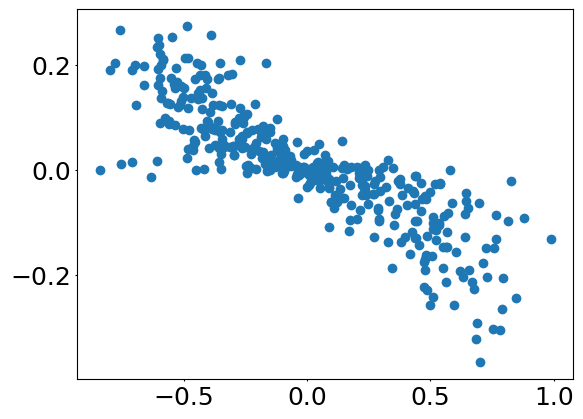

In [70]:
plt.scatter(gradient1f_hi, s)

In [71]:
spearmanr(gradient1f_hi, s)

SpearmanrResult(correlation=-0.900659969931609, pvalue=4.615542748244732e-145)

In [1009]:
order = np.argsort(gradient1f_hi)

# Structural gradients in null SC

In [203]:
null_SC = np.load('Results/null_SC_expanded_deltaD_30.npy')